In [1]:
%matplotlib notebook
%pylab
from scipy.interpolate import griddata
from matplotlib import cm

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
from module_2D_diffusion_bdf2_3 import*

In [3]:
def TempB(Sb, a,b,c,pb): 
    '''
    Sb: interface salinity
    pb: interface pressure
    a,b,c: constants
    TB = aSb + b + cpb 
    '''
    return a*Sb + b + c*pb

def Meltrate(Sw, Sb, gammaS): 
    '''
    Sw: ambient salinity
    Sb: interface salinity
    gammaS: salinity exchange velocity
    Melt rate: V = gammaS*(Sw - Sb)/Sb 
    '''
    return gammaS*(Sw - Sb)/Sb

def SaltB(K,L,M,Sw): 
    '''
    Interface salinity 
    '''
    D = L**2 - 4*K*M*Sw
    Sb1 = (-L + sqrt(D))/(2*K) 
    Sb2 = (-L - sqrt(D))/(2*K)
    
    # Check for possitive salinity
    if(Sb1 > 0):
        Sb = Sb1
    elif(Sb2 > 0):
        Sb = Sb2

    return Sb


# Coefficient in the quadratic equation for salinity at the boundary
def coefK(a, gammaS, gammaT,cw,cI):
    return a*(1 - gammaS*cI/(gammaT*cw))

def coefF(Tw, gammaS,gammaT, cw, Li, cI, TS, b, c, pb, a, Sw):
    A = -Tw - (gammaS/(cw*gammaT))*(Li - cI*TS) 
    B = (b + c*pb)*(1 - gammaS*cI/(cw*gammaT))
    C = a*(gammaS*cI/(cw*gammaT))*Sw
    return A + B + C

def coefM(gammaS, gammaT, cw, Li, cI, TS, a, b, c, pb):
    A = (gammaS/(cw*gammaT))*(Li - cI*TS) 
    B = cI*(gammaS/(cw*gammaT))*(b + c*pb)
    return A + B


# define exact, source functions
def initial_Temp(x, cst1):
    return cst1 + 9.5e-4*x

def initial_Salt(x, cst2):
    return cst2 + 4.0e-4*x
    
# Neumann boundary condition
def hT(bcst1, gammaT, TB,T,V):
    return (gammaT+ V)*(T-TB) #rho*bcst1*V 

def hB(bcst2,SB, S, gammaS,V):
    return (gammaS+ V)*(S-SB) #rho*bcst2*SB*V



# Values of the parameters in the ice-ocean simulation

a = -5.73e-2     # Salinity coefficient of freezing equation(˚C*psu^{-1})
b =  0#9.39e-2     # Constant coefficient of freezing equation(˚C)
c = 0#-7.53e-8     # Pressure coefficient of freezing equation(˚C*Pa^{-1})
ci = 2009.0      # Specific heat capacity ice(J*kg^-1*K^-1)
cw = 3974.0      # Specific heat capacity water(J*kg^-1*K^-1)
Li = 3.35e+5     # Latent heat fusion(J*kg^-1)
Tw = 2.3         # Temperature of water(˚C)
Ti = -25         # Temperature of ice(˚C)
Sw = 35          # Salinity of water(psu)
Sc = 2500        # Schmidt number
Pr = 14          # Prandtl number
mu = 1.95e-6     # Kinematic viscosity of sea water(m^2*s^-1)
pb = 1.0e+7      # Pressure at ice interface(Pa)
kT = mu/Pr       # Thermal diffusivity(m^2*s^-1)
kS = mu/Sc       # Salinity diffusivity(m^2*s^-1)

kT = 1.3e-7
kS = 7.4e-10
rhoI = 920       # density of ice(kg m^-3)
rhoW = 1025      # density of sea water(kg*m^-3)

gammaT = 5.0e-5        # Thermal exchange velocity(m*s^-1)

gammaS = 0.04*gammaT   # Salinity exchange velocity(m*s^-1)

rho = rhoI/rhoW        # report between ice density and seawater density

# Coeffecients in quadratic equation for salinity at the boundary

Kf = coefK(a, gammaS, gammaT,cw,ci)
Mf = coefM(gammaS, gammaT, cw, Li, ci, Ti, a, b, c, pb)


In [4]:
def ice_simulation(N,Q,nel,Np, ax, bx,ay,by, integration_type,\
                                            kstages, time_method,CFL,Tw,Tfinal,Nelx, Nely,\
                                            Nx, Ny, Nbound,Nside,x_boundary,y_boundary,mixed):
    # For temperature
    cst1 = Tw               # Constant that initialize the initial temperature
    c1 = kT                 # Temperature diffusivity
    bcst1 = Li/(cw)#*kT)      # Constant term for the temperature gradient at the boundary
    # For salinity
    cst2 = Sw               # Constant that initialize the initial salinity
    c2 = kS                 # Salinity diffusivity
    bcst2 = 1#/kS            # Constant term for the salinity gradient at the boundary

    # Call the ice-ocean solver for the diffusion problem

    '''
    outputs:
    --------
    S          : Salinity
    T          : Temperature
    coord      : All grid points
    intma      : Intma(CG/DG)
    '''

    S, T, coord, intma, tf = ice_ocean_Solver(N,Q,nel, Np, ax, bx,ay,by, integration_type, hT, hB, cst1,\
                        c1, bcst1,cst2, c2,bcst2,Tw, gammaS,gammaT, cw, Li, ci, Ti, b, c, pb, a,\
                        Sw, Kf, Mf, CFL, Tfinal,coefF, Meltrate, SaltB, time_method, Nelx, Nely,\
                        Nx, Ny, Nbound,Nside,kstages,x_boundary,y_boundary,mixed)
    
    return S,T,coord,intma,tf


In [5]:


'''
    Visualisation function

    Order           : contains the list of the polynomial order used in the numerical integration
    N_element       : contains the number of elements in the domain
    time_method     : time integration method
    ti_method       : stages of the time integration method (implicit Runge Kutta method)
    icase           : select the time of the boundary conditions you want to test
    method_type     : continous galerkin (cg) method, it is the only one implemented in Module_ice_ocean
    integration_type: exact or inexact integration
    text_case       : select either we are in unit test case or the ice-ocean simulation



'''

order = array([2])        # polynomial order
Nv = array([4])
kstages = 4
cfl = 0.25
dt = 1e-2
Tfinal = 100

time_method = "BDF2"      # IRK, BDF2 or BDF3
integration_type = 1      # % = 1 is inexact and = 2 is exact
iplot = False             # plot the solution
        
x_boundary = [7,5]    # Bottom and Top (x = -1 and x = +1)
y_boundary = [5,5]    # Left and Right (y = -1 and x = +1)

mixed = True
# Domain and diffusion coefficient



# Simulation domain
ax = 0
bx = 0.1
ay = 0
by = 0.2

# Initialization
u = 1.5

Tw = 2.3

for iN,N in enumerate(order):

    cfl = 1/(N+1)                     # CFL number

    if (integration_type == 1):       # Inexact integration
        Q = N
    elif (integration_type == 2):     # Exact integration
        Q = N+1

    wall = 0

    for e, nel in enumerate(Nv):

        Nelx = nel; Nely = nel
        Nx = Nelx*N+1
        Ny = Nely*N+1
        Np = Nx*Ny
        Ne = Nelx*Nely
        Nbound = 2*Nx + 2*(Ny-2)
        Nside = 2*Ne + Nelx + Nely

        # Call the ice-ocean solver from Inputs module

        '''
        outputs:
        --------
        S          : Salinity
        T          : Temperature
        coord      : All grid points
        intma      : Intma(CG/DG)
        '''

        S,T,coord,intma,tf = ice_simulation(N,Q,Ne,Np, ax, bx,ay,by, integration_type,\
                                            kstages, time_method,cfl,Tw,Tfinal,Nelx, Nely,\
                                            Nx, Ny, Nbound,Nside,x_boundary,y_boundary,mixed)

        print("\twalltime = {:e}".format(tf))

        toc = perf_counter()
        #wall += toc - tic

# End of the simulation


N = 2, nel = 16, Np = 81
	dt = 9.9990e-03
	Number of time steps = 10001
	walltime = 6.021886e+00


In [6]:
#intma

In [7]:
xmin = min(coord[:,0])
xmax = max(coord[:,0])
ymin = min(coord[:,1])
ymax = max(coord[:,1])
xe = coord[:,0]
ye = coord[:,1]
nx = 200
ny = 200
dx = (xmax-xmin)/nx
dy = (ymax-ymin)/ny
x1 = arange(xmin,xmax+dx,dx)
y1 = arange(ymin,ymax+dy,dy)
xi,yi = meshgrid(x1,y1)

<IPython.core.display.Javascript object>


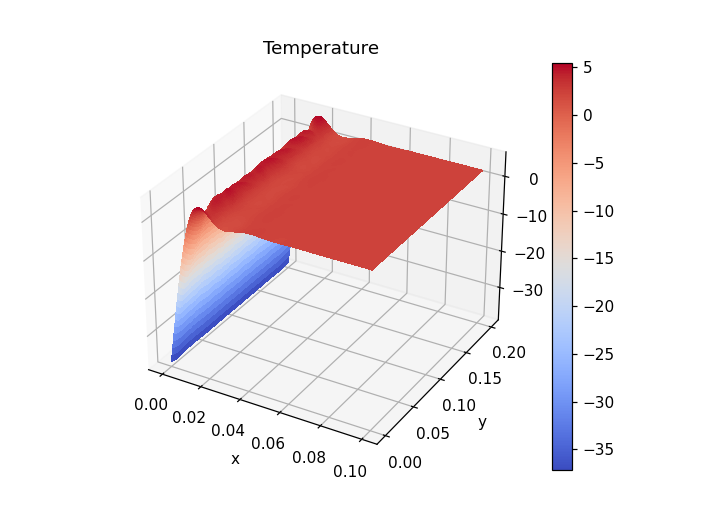

In [8]:
T_2d = griddata((xe,ye),T,(xi,yi), method='cubic')

fig = figure(1)
fx = fig.add_subplot(111, projection='3d')
surf = fx.plot_surface(xi,yi,T_2d,rstride = 1, cmap=cm.coolwarm,cstride = 1,antialiased=False)
fig.colorbar(surf)

title("Temperature")
xlabel("x")
ylabel("y")

show()

<IPython.core.display.Javascript object>


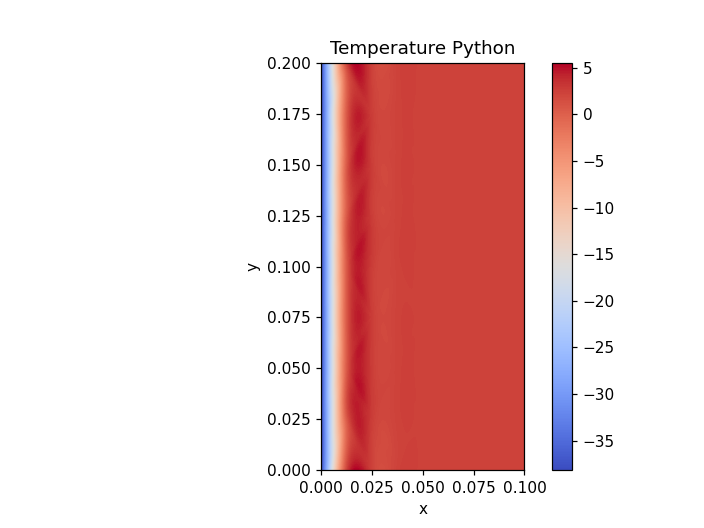

In [9]:
figure(2)
imshow(T_2d, extent=[ax, bx, ay, by],origin='lower',cmap=cm.coolwarm) # ocean, Blues, terrain, cm.coolwarm
colorbar()
#clim(T.min(), T.max())
title("Temperature Python")
xlabel("x")
ylabel("y")
show()

<IPython.core.display.Javascript object>


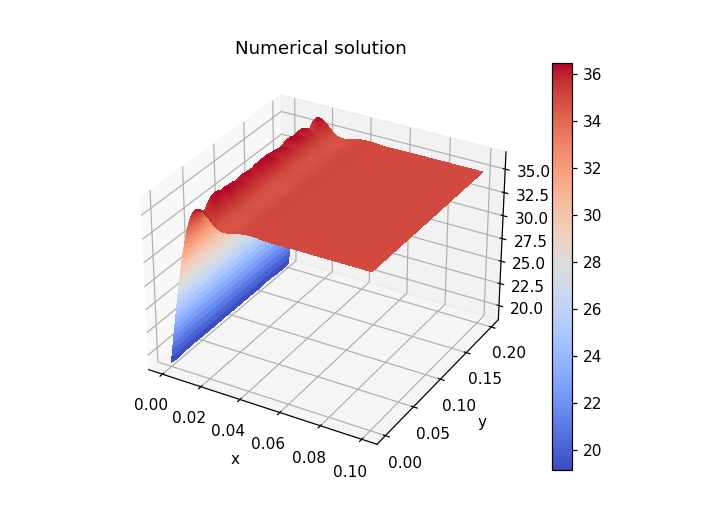

In [10]:
S_2d = griddata((xe,ye),S,(xi,yi), method='cubic')

fig = figure(3)
fx = fig.add_subplot(111, projection='3d')
surf = fx.plot_surface(xi,yi,S_2d,rstride = 1, cmap=cm.coolwarm,cstride = 1,antialiased=False)
fig.colorbar(surf)

title("Numerical solution")
xlabel("x")
ylabel("y")

show()

<IPython.core.display.Javascript object>


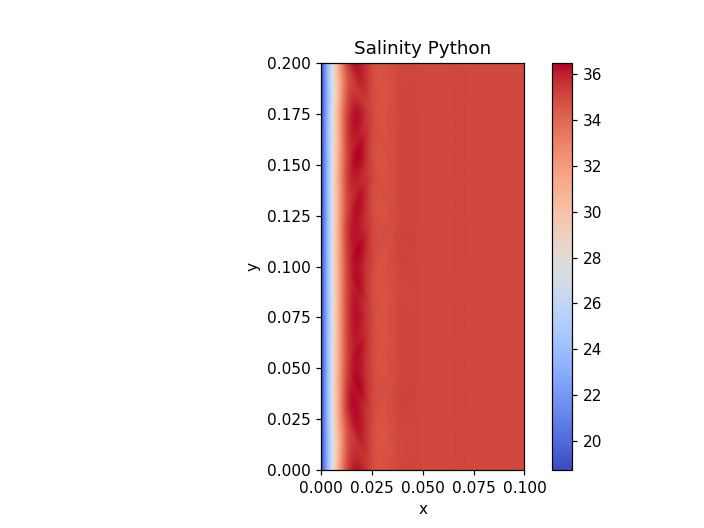

In [11]:
figure(4)
imshow(S_2d, extent=[ax, bx, ay, by],origin='lower',cmap=cm.coolwarm)
colorbar()
#clim(S.min(), S.max())
title("Salinity Python")
xlabel("x")
ylabel("y")
show()

In [12]:
print("min_q  = ",T.min())

print("\nmax_q  = ",T.max())

min_q  =  -37.81706789216162

max_q  =  2.608927640824358
